# Modeling
## Estancia de investigación Maestría de Ciencia de Datos
## Aide Jazmín González Cruz

### 1. Carga de librerías

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from siuba import *
import time
from time import gmtime, strftime

import sys
import os
from os.path import dirname
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
sys.path.append(dirname('../src'))
from src.utils import utils

### 2. Carga de features y división de datos de entrenamiento y validación

In [2]:
df = utils.load_df("../Data/feature_selection.pkl")
df.head(5)

,ventana,max_altura,min_preglucosa,num_med_preglucosa,max_edad,min_edad,max_dif_vent_entre_consul,max_sistolica_a,avg_preglucosa,avg_edad,...,tumores_benignos,hdl,altura,comp_precoces_traumatismos,avg_enf_aparato_urinario,enf_circulacion_pulmonar_enf_corazon,malformaciones_congenitas,fiebre_y_enf_cardiacas_reumaticas,imc,label
0,1.0,1.64,108.000000,9.000000,49.0,47.0,100.0,130.0,150.000000,48.160000,...,0.0,0.0,1.0,1.0,0.9,0.0,1.0,1.0,1.0,0
1,2.0,1.64,109.000000,4.000000,50.0,48.0,69.0,130.0,158.000000,49.000000,...,0.0,0.0,1.0,1.0,0.9,0.0,1.0,1.0,1.0,0
2,3.0,1.64,253.000000,1.000000,51.0,49.0,69.0,130.0,253.000000,50.142857,...,0.0,0.0,1.0,1.0,0.9,0.0,1.0,1.0,1.0,0
3,4.0,1.64,80.000000,4.000000,52.0,50.0,112.0,160.0,155.750000,51.200000,...,0.0,0.0,1.0,1.0,0.9,0.0,1.0,1.0,1.0,1
4,1.0,1.76,125.188235,3.941176,33.0,32.0,542.0,100.0,157.012007,32.500000,...,0.0,0.0,1.0,1.0,0.9,0.0,1.0,1.0,1.0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Columns: 138 entries, ventana to label
dtypes: float64(137), int64(1)
memory usage: 166.2 KB


In [4]:
X = df.loc[:, df.columns != 'label']
print(X.shape)
Y = df[["label"]]
print(Y.shape)

(154, 137)
(154, 1)


In [5]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3)

### 3. Magic Loop

- Diccionario de algoritmos a aplicar

In [6]:
algorithms_dict = {'tree': 'tree_grid_search',
                   'random_forest': 'rf_grid_search',
                   'logistic': 'logistic_grid_search',
                   'xgboost': 'xgboost_grid_search'}

- Diccionario de configuraciones

In [7]:
grid_search_dict = {
                        'tree_grid_search': {
                            'max_depth': [5, 10, 15],
                            'min_samples_leaf': [3, 5, 7]
                        },
                        'rf_grid_search': {
                            'n_estimators': [30, 50, 100],
                            'max_depth': [5, 10, 15],
                            'min_samples_leaf': [3, 5, 10]
                        },
                        'logistic_grid_search':{
                            'C':np.logspace(-3,3,7),
                            'penalty':['l2']
                        },
                        'xgboost_grid_search':{
                            'max_depth': range (2, 10, 1),
                            'n_estimators': range(60, 220, 40),
                            'learning_rate': [0.1, 0.01, 0.05]
                        }
                    }

- Diccionario de estimadores

In [8]:
from xgboost import XGBClassifier

In [9]:
from sklearn.tree import DecisionTreeClassifier
estimators_dict = {'tree': DecisionTreeClassifier(random_state=1111),
                   'random_forest': RandomForestClassifier(oob_score=True, random_state=2222),
                   'logistic': LogisticRegression(random_state=3333),
                   'xgboost': XGBClassifier(objective= 'binary:logistic',nthread=4,seed=42)
                  } 

In [10]:
def magic_loop(algorithms, features, labels):
    best_estimators = []
    for algorithm in algorithms:
        estimator = estimators_dict[algorithm]
        grid_search_to_look = algorithms_dict[algorithm]
        grid_params = grid_search_dict[grid_search_to_look]
        #tscv = TimeSeriesSplit(n_splits=5)
        
        #gs = GridSearchCV(estimator, grid_params, scoring='precision', cv=5, n_jobs=-1)
        gs = GridSearchCV(estimator, grid_params, scoring='roc_auc', cv=5, n_jobs=-1)
        
        #train
        gs.fit(features, labels)
        #best estimator
        best_estimators.append(gs)
        
        
    return best_estimators

In [11]:
#scoring_met= 'recall'
algorithms = ['tree', 'random_forest','logistic','xgboost']
models = []
start_time = time.time()
models_list = []

In [12]:
X_train.columns.values.tolist()

['ventana',
 'max_altura',
 'min_preglucosa',
 'num_med_preglucosa',
 'max_edad',
 'min_edad',
 'max_dif_vent_entre_consul',
 'max_sistolica_a',
 'avg_preglucosa',
 'avg_edad',
 'max_preglucosa',
 'avg_enf_endocrinas',
 'avg_altura',
 'avg_sistolica_a',
 'avg_vent_entre_consul',
 'avg_peso',
 'min_altura',
 'max_peso',
 'num_med_presion_a',
 'min_peso',
 'sum_num_consultas',
 'avg_dif_imc_calculado',
 'min_sistolica_a',
 'min_dif_imc_calculado',
 'num_med_altura',
 'avg_diastolica_a',
 'max_dif_imc_calculado',
 'dm',
 'min_dif_vent_entre_consul',
 'num_med_sintomas_signos_hallazgos_anormales_clin_lab_no_clasif',
 'num_med_edad',
 'min_diastolica_a',
 'num_med_imc_calculado',
 'avg_num_consultas_by_year',
 'num_med_comp_precoces_traumatismos',
 'avg_trastornos_sist_genitourinario_consec_proced',
 'num_med_enf_sist_nervioso',
 'num_med_peso',
 'num_med_tumores_malig_org_respiratorios_intratoracicos',
 'num_med_colesterol',
 'avg_fiebre_y_enf_cardiacas_reumaticas',
 'avg_enf_sist_nervioso

In [13]:
best = magic_loop(algorithms, X_train, y_train)
print("Selección de variables completada satisfactoriamente en ", time.time() - start_time, ' segundos')

Selección de variables completada satisfactoriamente en  3775.569453239441  segundos


In [14]:
model = best[0].best_estimator_
model

DecisionTreeClassifier(max_depth=5, min_samples_leaf=7, random_state=1111)

In [15]:
utils.save_df(model, "../output/best_model.pkl")

### 4. Evaluando modelo

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score
import matplotlib.pyplot as plt

In [17]:
predicted_labels = model.predict(X_test)
predicted_scores = model.predict_proba(X_test)

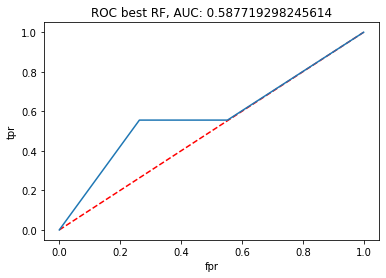

In [18]:
### Curva ROC
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:, 1], pos_label=1)
plt.clf()
plt.plot([0, 1], [0, 1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels)))
plt.xlabel("fpr")
plt.ylabel("tpr")
#plt.savefig('../output/ROC_curve.png', bbox_inches='tight')
plt.show()

In [19]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2, 'precision': precision,
                         'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)

    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']

    df = df_1.merge(df_2, on="threshold")

    return df

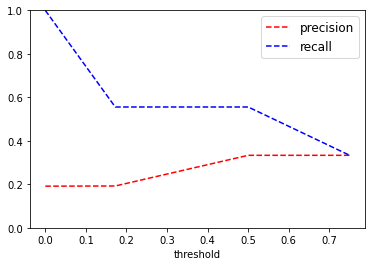

In [20]:
# Generando métricas
precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores[:, 1], pos_label=1)
thresholds_2 = np.append(thresholds_2, 1)
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
#save_metrics(metrics_report, '../output/metricas_offline.pkl')

# Curva: Precision-recall
plt.figure()
plt.plot(metrics_report['threshold'], metrics_report['precision'], 'k--', c="red", label='precision')
plt.plot(metrics_report['threshold'], metrics_report['recall'], 'k--', c="blue", label='recall')
plt.xlabel('threshold')
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1, 1), fontsize=12)
plt.savefig('../output/recall_precision.png', bbox_inches='tight')
#plt.show()

In [21]:
# Curva: recall-precision @k
data_junta = pd.concat([X_test, y_test], axis=1)
data_filtrada = data_junta
datos_finales_X = pd.DataFrame(data_filtrada.drop(['label'], axis=1))
y_true = data_filtrada.label
y_scores = model.predict_proba(datos_finales_X)

In [22]:
def param_graf(y_true, y_scores):
    k_values = np.linspace(0, 0.99, 100)
    lista = []

    for k in k_values:
        p_k = precision_at_k(y_true, pd.DataFrame(y_scores)[1], k)
        r_k = recall_at_k(y_true, pd.DataFrame(y_scores)[1], k)
        lista = lista + [[p_k, r_k, k]]

    p_r_g = pd.DataFrame(lista, columns=["p_k", "r_k", "k"])

    return p_r_g

def precision_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k * len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return precision_score(y_true, y_pred)

def recall_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k * len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return recall_score(y_true, y_pred)

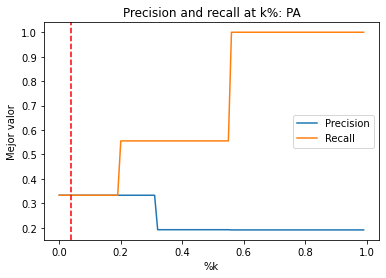

In [23]:
p_r_g = param_graf(y_true, y_scores)

plt.figure()
plt.plot(p_r_g["k"], p_r_g["p_k"], label="P")
plt.plot(p_r_g["k"], p_r_g["r_k"], label="R")
plt.title("Precision and recall at k%: PA")
plt.axvline(x=0.037, c='red', linestyle='--')
plt.ylabel("Mejor valor")
plt.legend(['Precision', 'Recall'])
plt.xlabel("%k")
plt.savefig('../output/recall_precision_k.png', bbox_inches='tight')
#plt.show()